# Data visualisation — Descriptives (Yields)

This notebook reproduces the *Descriptives* visualisations using the **raw `Yields.csv`** (and keeps the same file-loading logic as `data_visualisation.ipynb`).

Visualisations:
1. **Boxplots**: yield distribution for the **10 most frequent crops** and **10 most frequent municipalities**
2. **Density heatmap**: **Municipality × Crop** (counts)

> Frequency is computed **independently of `Variety`**: rows are first collapsed to unique `(Year, Municipality, Crop)` (mean yield across varieties for that triplet), so a municipality-year-crop combination counts as **1** even if multiple varieties exist.


In [7]:
# === Parameters (easy to tweak) ===
DATA_DIR = "./data"   # keep the same logic as your existing notebook

YIELDS_FILE = f"{DATA_DIR}/Yields.csv"
WEATHER_FILE = f"{DATA_DIR}/Weather Reanalysis.csv"  # read for consistency (not used in the plots)

TOP_K = 10  # for boxplots

# Heatmap sizing: keep only the most frequent categories to avoid an unreadable huge heatmap
HEATMAP_TOP_MUNIS = 30
HEATMAP_TOP_CROPS = 30


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

def _pick_yield_col(df: pd.DataFrame, candidates: list[str]) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(
        "Could not find a yield column. "
        f"Tried: {candidates}. Available columns: {list(df.columns)}"
    )

def _standardize_str(s: pd.Series) -> pd.Series:
    # light standardization for consistent grouping/labels (does not change numeric data)
    return s.astype(str).str.strip().str.upper()

# --- Load files (same logic as data_visualisation.ipynb) ---
df_yields = pd.read_csv(YIELDS_FILE)
df_weather = pd.read_csv(WEATHER_FILE)

print("Yields shape:", df_yields.shape)
print("Weather shape:", df_weather.shape)

# Tidy column names (strip whitespace)
df_yields.columns = [c.strip() for c in df_yields.columns]
df_weather.columns = [c.strip() for c in df_weather.columns]

# Required columns
required = ["Year", "Municipality", "Crop"]
missing = [c for c in required if c not in df_yields.columns]
if missing:
    raise ValueError(f"Yields.csv is missing required columns: {missing}. Found: {list(df_yields.columns)}")

# Standardize keys for grouping (strings only)
df_yields = df_yields.copy()
df_yields["Municipality"] = _standardize_str(df_yields["Municipality"])
df_yields["Crop"] = _standardize_str(df_yields["Crop"])

# Keep only relevant columns for plotting (no feature engineering / no saving)
df_plot_raw = df_yields[["Year", "Municipality", "Crop", "Yield/Acre"]].dropna(subset=["Year", "Municipality", "Crop", "Yield/Acre"]).copy()

# Collapse varieties implicitly: unique (Year, Municipality, Crop)
# - this ensures frequency counts are independent of Variety
df_plot = (
    df_plot_raw
    .groupby(["Year", "Municipality", "Crop"], as_index=False)["Yield/Acre"]
    .mean()
)

print("Plot dataset shape (collapsed to Year×Municipality×Crop):", df_plot.shape)


Yields shape: (44448, 9)
Weather shape: (490896, 9)
Plot dataset shape (collapsed to Year×Municipality×Crop): (14476, 4)


In [9]:
# === Basic dataset info ===

n_crops = df_yields["Crop"].nunique(dropna=True)
n_munis = df_yields["Municipality"].nunique(dropna=True)
print(f"- number of different crops: {n_crops}") # 53 crops expected
print(f"- number of different municipalities in df_yields: {n_munis}") # 99 municipalities expected

n_munis = df_weather["Municipality"].nunique(dropna=True)
print(f"- number of different municipalities in df_weather: {n_munis}") # 84 municipalities expected

# filter df_yields to contain the same municipalitys as in df_weather
munis_weather = df_weather["Municipality"].unique()
df_yields = df_yields[df_yields["Municipality"].isin(munis_weather)]
n_munis = df_yields["Municipality"].nunique(dropna=True)
print(f"- number of different municipalities after filtering: {n_munis}")

- number of different crops: 53
- number of different municipalities in df_yields: 99
- number of different municipalities in df_weather: 84
- number of different municipalities after filtering: 84


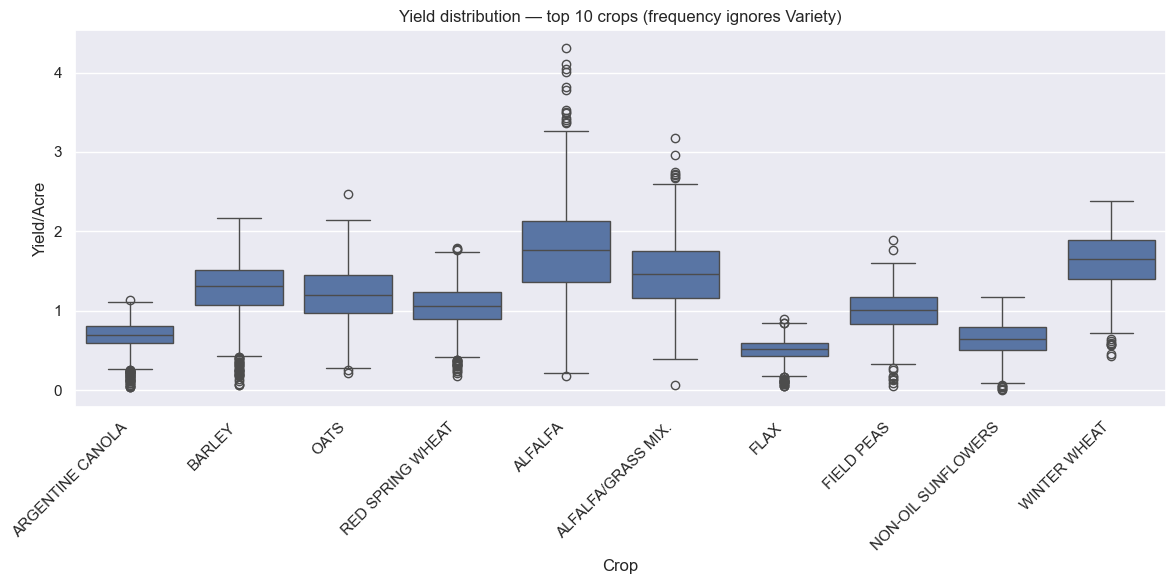

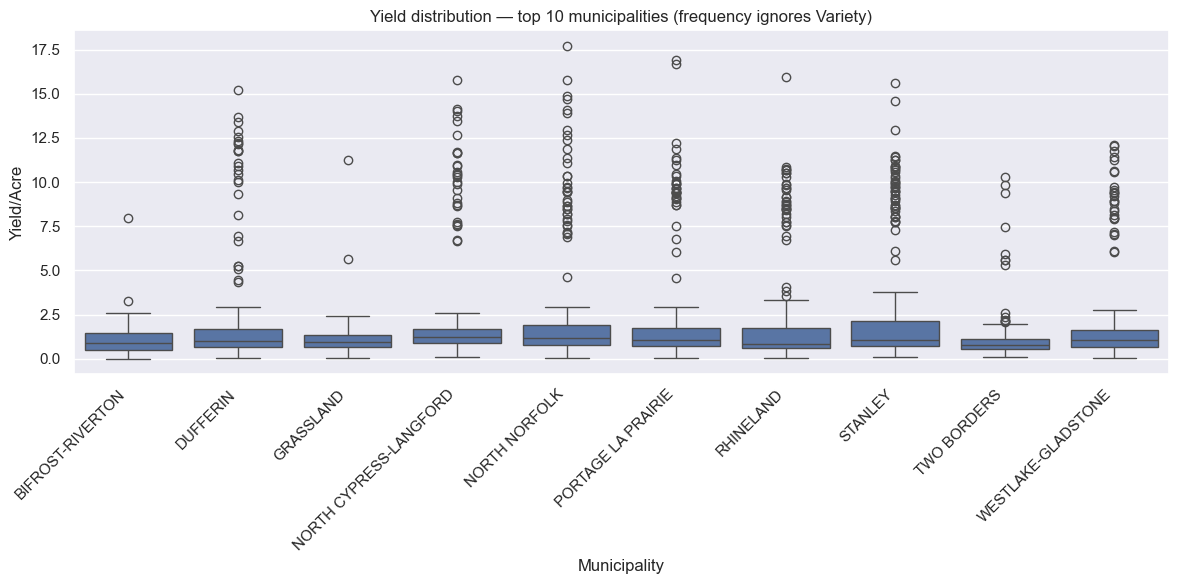

In [10]:
# === 1) Boxplots: yield distribution for TOP_K crops and municipalities ===

# Top crops by frequency (unique Year×Municipality×Crop)
top_crops = df_plot["Crop"].value_counts().head(TOP_K).index
df_top_crops = df_plot[df_plot["Crop"].isin(top_crops)].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_crops, x="Crop", y="Yield/Acre")
plt.xticks(rotation=45, ha="right")
plt.title(f"Yield distribution — top {TOP_K} crops (frequency ignores Variety)")
plt.tight_layout()
plt.show()

# Top municipalities by frequency (unique Year×Municipality×Crop)
top_munis = df_plot["Municipality"].value_counts().head(TOP_K).index
df_top_munis = df_plot[df_plot["Municipality"].isin(top_munis)].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_munis, x="Municipality", y="Yield/Acre")
plt.xticks(rotation=45, ha="right")
plt.title(f"Yield distribution — top {TOP_K} municipalities (frequency ignores Variety)")
plt.tight_layout()
plt.show()


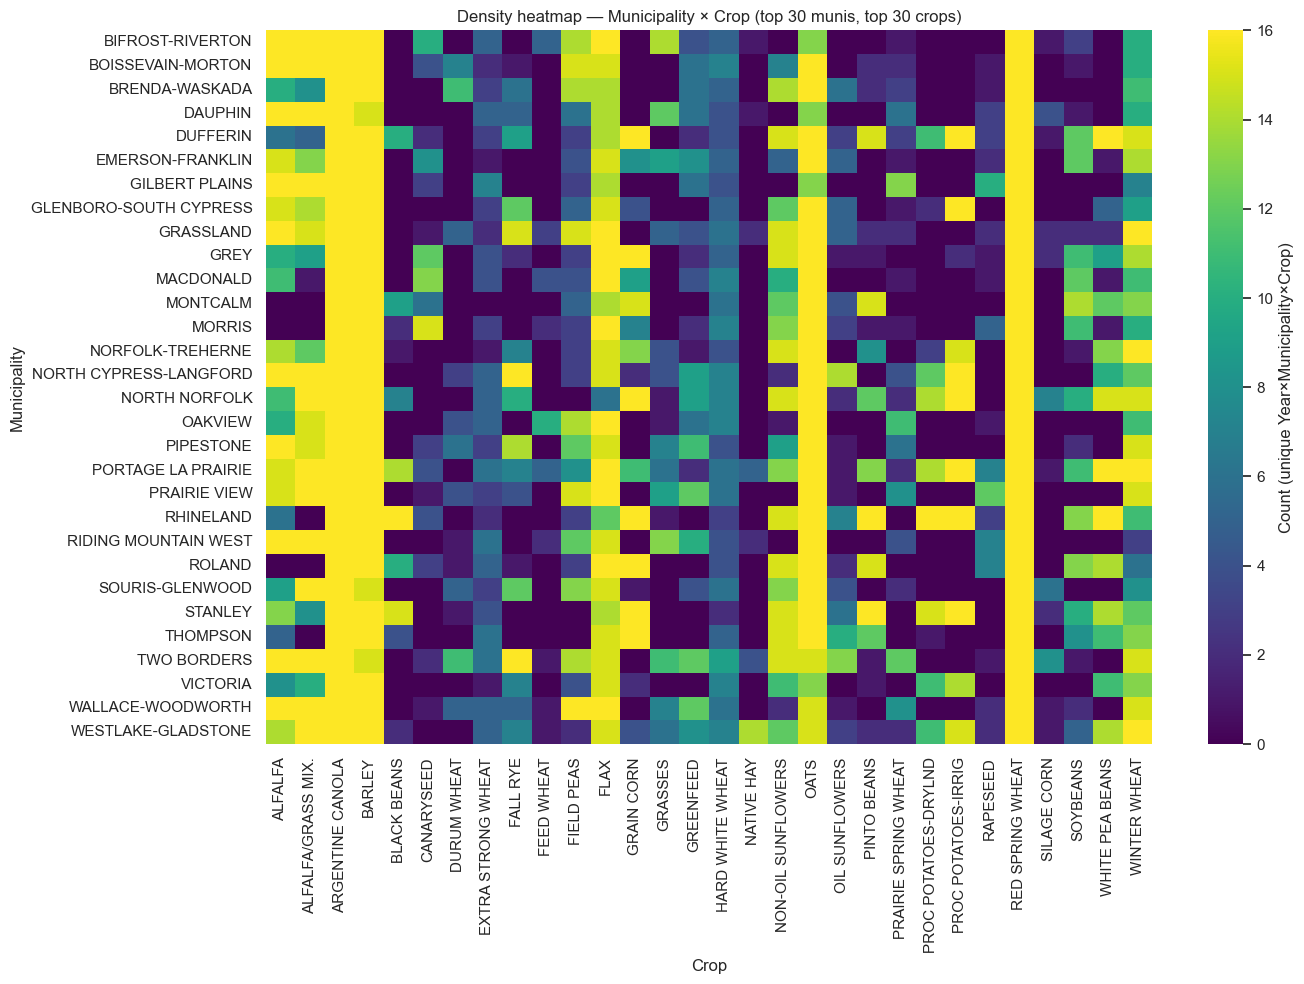

Heatmap table shape: (30, 30)


In [11]:
# === 2) Density heatmap: Municipality × Crop (counts) ===
# Counts are based on unique Year×Municipality×Crop, so they are independent of Variety.

# Choose most frequent municipalities/crops to keep the plot readable
muni_keep = df_plot["Municipality"].value_counts().head(HEATMAP_TOP_MUNIS).index
crop_keep = df_plot["Crop"].value_counts().head(HEATMAP_TOP_CROPS).index

df_hm = df_plot[df_plot["Municipality"].isin(muni_keep) & df_plot["Crop"].isin(crop_keep)].copy()

# Pivot to a count table
pivot_counts = df_hm.pivot_table(
    index="Municipality",
    columns="Crop",
    values="Yield/Acre",
    aggfunc="count",
    fill_value=0,
)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_counts, cmap="viridis", cbar_kws={"label": "Count (unique Year×Municipality×Crop)"})
plt.title(f"Density heatmap — Municipality × Crop (top {HEATMAP_TOP_MUNIS} munis, top {HEATMAP_TOP_CROPS} crops)")
plt.xlabel("Crop")
plt.ylabel("Municipality")
plt.tight_layout()
plt.show()

print("Heatmap table shape:", pivot_counts.shape)


🔝 Top 3 combinaisons Municipality + Crop :
     Municipality              Crop  count
1403   WHITEMOUTH  RED SPRING WHEAT     16
38         ARGYLE  RED SPRING WHEAT     16
1068       ROLAND            BARLEY     16


C:\Users\henri\AppData\Local\Temp\ipykernel_31136\3394213095.py:62: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\henri\Desktop\PSC\Data-study\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


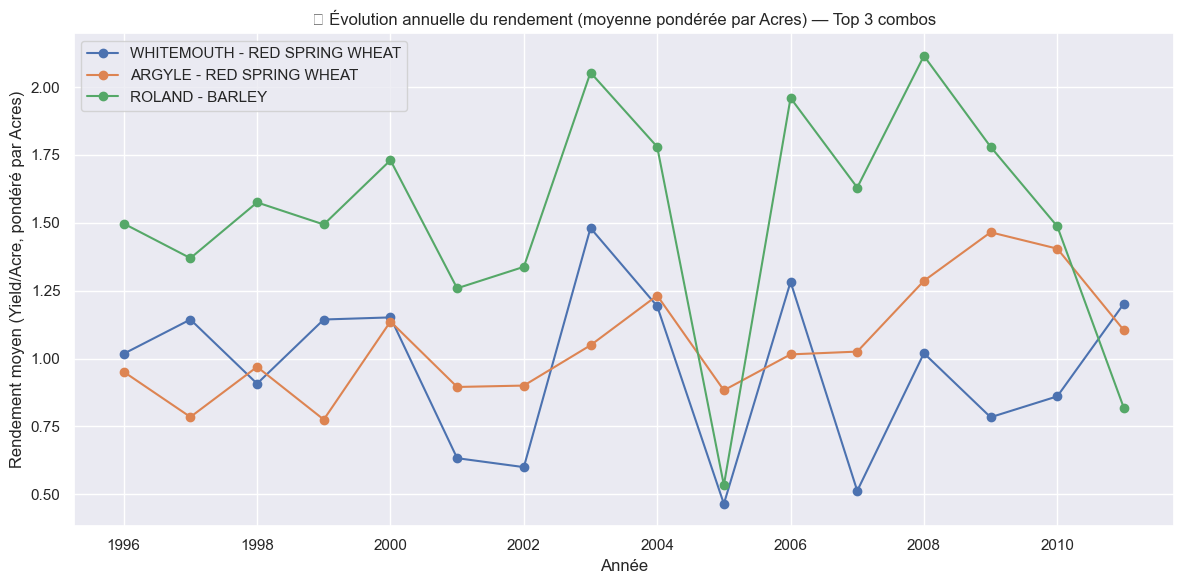

In [12]:
# --- 1) Collapse varieties: work at (Year, Municipality, Crop) level ---
df_base = (
    df_yields.groupby(["Year", "Municipality", "Crop"], as_index=False)
      .agg(
          Acres=("Acres", "sum"),
          YieldAcre_mean=("Yield/Acre", "mean")  # fallback if needed
      )
)

# Area-weighted mean yield per acre for each (Year, Municipality, Crop):
#   mean_yield = sum_i (yield_i * acres_i) / sum_i acres_i
tmp = df_yields.assign(_prod=df_yields["Yield/Acre"] * df_yields["Acres"])
df_weighted = (
    tmp.groupby(["Year", "Municipality", "Crop"], as_index=False)
       .agg(
           Acres=("Acres", "sum"),
           Prod=(" _prod".strip(), "sum")  # trick to keep simple; see below
       )
)
# If the "Prod" line above feels weird, just do it explicitly:
# df_weighted = (
#     tmp.groupby(["Year", "Municipality", "Crop"], as_index=False)
#        .agg(Acres=("Acres","sum"), Prod=("_prod","sum"))
# )

df_weighted["Mean_Yield"] = df_weighted["Prod"] / df_weighted["Acres"]

# --- 2) Top-3 most frequent Municipality×Crop combos (frequency independent of Variety) ---
combo_counts = (
    df_weighted.groupby(["Municipality", "Crop"], as_index=False)
               .size()
               .rename(columns={"size": "count"})
)
top3_combos = combo_counts.sort_values("count", ascending=False).head(3)

print("🔝 Top 3 combinaisons Municipality + Crop :")
print(top3_combos)

# --- 3) Plot annual evolution of mean yield for each top combo ---
plt.figure(figsize=(12, 6))

for _, row in top3_combos.iterrows():
    muni, crop = row["Municipality"], row["Crop"]
    df_subset = df_weighted[(df_weighted["Municipality"] == muni) & (df_weighted["Crop"] == crop)]

    df_year = (
        df_subset.groupby("Year", as_index=False)
                 .agg(
                     Acres=("Acres", "sum"),
                     Prod=("Prod", "sum")
                 )
    )
    df_year["Mean_Yield"] = df_year["Prod"] / df_year["Acres"]

    plt.plot(df_year["Year"], df_year["Mean_Yield"], marker="o", label=f"{muni} - {crop}")

plt.title("📈 Évolution annuelle du rendement (moyenne pondérée par Acres) — Top 3 combos")
plt.xlabel("Année")
plt.ylabel("Rendement moyen (Yield/Acre, pondéré par Acres)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()